# Non manhattan routing

gdsfactory provides functions to connect and route components ports that are off-grid or have non manhattan orientations (0, 90, 180, 270 degrees)

## Fix Non manhattan connections

The GDS format often has issues with non-manhattan shapes, due to the rounding of vertices to a unit grid and to downstream tools (i.e. DRC) which often tend to assume cell references only have rotations at 90 degree intervals. For example:

In [ ]:
from gdsfactory.decorators import has_valid_transformations
import gdsfactory as gf
from gdsfactory.generic_tech import get_generic_pdk

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()


@gf.cell
def demo_non_manhattan():
    c = gf.Component("bend")
    b = c << gf.components.bend_circular(angle=30)
    s = c << gf.components.straight(length=5)
    s.connect("o1", b.ports["o2"])
    return c


c1 = demo_non_manhattan()
print(has_valid_transformations(c1))
c1

if you zoom in between the bends you will see a notch between waveguides due to non-manhattan connection between the bends.

![gap](https://i.imgur.com/jBEwy9T.png)

You an fix it with the `flatten_invalid_refs` flag when you call `Component.write_gds()`.

In [ ]:
help(c1.write_gds)

In [ ]:
gdspath = c1.write_gds(flatten_invalid_refs=True)
c2 = gf.import_gds(gdspath)
c2

In [ ]:
has_valid_transformations(c1)  # has gap issues

In [ ]:
has_valid_transformations(c2)  # works perfect

If you zoom in the connection the decorator you can see it fixed the issue in `c` that we fixed in `c2` thanks to the `flatten_invalid_refs` flag.

![no gap](https://i.imgur.com/VbSgIjP.png)

### Default PDK `GdsWriteSettings`
If you are frequently (or even sometimes!) creating geometries like this, with non-manhattan ports and/or references with non-90-degree rotations, I highly recommend that you set `flatten_invalid_refs=True` in your PDK's `GdsWriteSettings`. If you are the PDK author, you can do this in the definition of the pdk. Or, you can modify the PDK at runtime like.

In [ ]:
pdk = gf.get_active_pdk()
pdk.gds_write_settings.flatten_invalid_refs = True

With this flag set, invalid references will be flattened by default, preventing gaps and errors in downstream tools which may not support cell references with arbitrary rotation, without needing to specify this on each GDS write.

You should note, however, that this will *not* fix all gaps between faces of unequal length, as it is *impossible* to guarantee this for diagonal line segments of unequal lengths constrained to end on integer grid values.

## Non-manhattan router
<div class="alert alert-block alert-warning">
<b>Warning:</b> It is highly advised that you follow the above instructions and set your PDK to <b>flatten invalid refs on GDS write by default</b> if you intend to use the non-manhattan router.
</div>

The non-manhattan (all-angle) router allows you to route between ports and in directions which are not aligned with the x and y axes, which is the constraint of most other gdsfactory routers. Unlike phidl's `smooth()` however, the all-angle router 

- has a `steps` based syntax, fully compatible with the yaml-based circuit flow
- builds paths from available PDK components, such that routes can be simulated naturally by S-matrix-based circuit modeling tools, like SAX
- allows for advanced logic in selecting appropriate bends, cross-sections, and automatic tapers, based on context
- includes advanced cross-section-aware bundling logic

### A simple route
Let's start with a simple route between two non-orthogonal ports.
Consider the yaml-based pic below.

In [ ]:
from gdsfactory.read import cell_from_yaml_template
from IPython.display import Code
from pathlib import Path
from IPython.display import display

def show_yaml_pic(filepath):
    gf.clear_cache()
    cell_name = filepath.stem
    return display(Code(filename=filepath, language='yaml+jinja'), cell_from_yaml_template(filepath, name=cell_name)())

# we're going to use yaml-based PICs for our examples. you can find them in docs/notebooks/yaml_pics
# if you'd like to tweak and play along
sample_dir = Path('yaml_pics')

basic_sample_fn = sample_dir / 'aar_simple.pic.yml'
show_yaml_pic(basic_sample_fn)

You can see that even though one of the ports was non-orthogonal, the route was completed, using non-90-degree bends. The logic of how this works is explained further in the next section

### Bends and connectors
Let's first consider the "simple" case, as shown above, where the vectors of the two ports to route between intersect at a point. The logic for how to build the route is as follows:

1. Find the intersection point of the two port vectors.
2. Place the bend at the intersection point of the two vectors by its "handle". The bend's handle is the point of intersetion of it's inverted port vectors (i.e. if the ports were pointed inwards rather than outwards). For any arbitrary bend, this guarantees that the ports of the bend will be in the straight line of sight of the ports which they should connect to, inset by some amount.
3. Call the route or segment's specified connector function to generate a straight section between the bend's ports and their adjacent ports.

Now, this is where it gets fun. Since we've calculated our bend first and worked backwards, we know how much room we have for the straight connector, and we can take that into consideration when creating it.

The three connectors available by default are

- `low_loss`: auto-tapers to the lowest-loss cross-section possible to fit in the given segment
- `auto_taper`: auto-tapers to the cross-section specified, based on the active pdk's specified `layer_transitions`
- `simple`: simply routes with a straight in the cross-section specified (no auto-tapering)

You can also define your own connector, as a function of the two ports which should be connected and the (suggested) cross-section. See the example below, which implements a very custom connector, composed of two sine bends and a physical label.

In [ ]:
import gdsfactory.routing.all_angle as aar
import numpy as np

def wonky_connector(port1, port2, cross_section):
    # let's make a wavy-looking connector of two sine tapers, each half the length of the total connector
    # we'll let cross_section define the cross-section at the *center* of the connector here
    connector_length = np.linalg.norm(port2.center - port1.center)
    t1 = gf.components.taper_cross_section_sine(length=0.5 * connector_length, 
                                                cross_section1=port1.cross_section,
                                                cross_section2=cross_section).ref().connect('o1', port1)
    t1.info['length'] = connector_length * 0.5
    t2 = gf.components.taper_cross_section_sine(length=0.5 * connector_length, 
                                                cross_section1=port2.cross_section,
                                                cross_section2=cross_section).ref().connect('o1', port2)
    t2.info['length'] = connector_length * 0.5
    center_port = t1.ports['o2']
    # just for fun-- we can add a non-functional reference also
    label = gf.components.text(f'W = {center_port.width}, L = {connector_length:.3f}', size=center_port.width * 0.5, justify="center", layer="M1").ref()
    label.move(label.center, destination=center_port.center + (0, center_port.width)).rotate(center_port.orientation, center=center_port.center)
    label.info['length'] = 0
    return [t1, t2, label]

# register the connector so it can be used by name
aar.CONNECTORS['wonky'] = wonky_connector

wonky_fn = sample_dir / 'aar_wonky_connector.pic.yml'
show_yaml_pic(wonky_fn)

### Indirect routes
Indirect routes are those in which the port vectors do not intersect. In this case, you will see that an S-like bend is created. 

In [ ]:
indirect_fn = sample_dir / "aar_indirect.pic.yml"
show_yaml_pic(indirect_fn)

This is also capable of looping around, i.e. for ~180 degree connections.

In [ ]:
show_yaml_pic(sample_dir / 'aar_around_the_back.pic.yml')

We can fine-tune how this looks by adjusting the `start_angle` and `end_angle` of the route, which will abut a bend to the start/end ports such that they exit at the angle specified.

In [ ]:
show_yaml_pic(sample_dir / 'aar_around_the_back2.pic.yml')

You may also want to further customize the bend used in the route, as shown below.

In [ ]:
show_yaml_pic(sample_dir / 'aar_around_the_back3.pic.yml')

### Steps
For more complex routes, i.e. when weaving around obstacles, you may want to fine-tune the path that the route traverses. We can do this by defining `steps`.

In [ ]:
show_yaml_pic(sample_dir / 'aar_steps01.pic.yml')

There are many different parameters you can put in the step directives. To make a complex route like this, a great way is to first sketch it out with the klayout ruler, then convert it to a set of `ds` and `exit_angle` step directives. Combine this with `gf watch` for live file-watching, and you can quickly iterate to achieve your desired route.


For example, consider the following circuit. Let's start with the same two MMIs and obstacle as in the previous example.

In [ ]:
show_yaml_pic(sample_dir / "aar_steps02_initial.pic.yml")

First, trace the path you would like to take with the ruler, as shown below. 

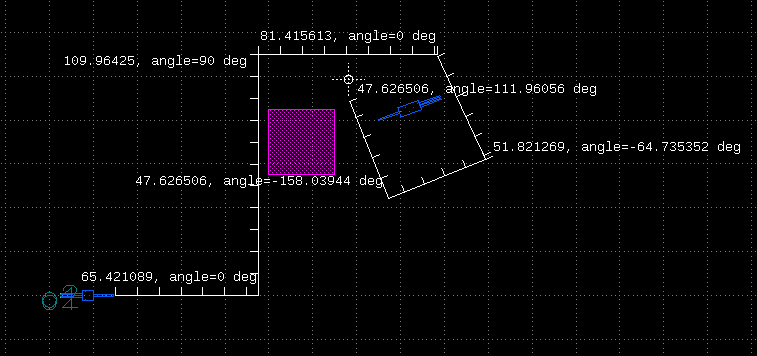

 <div class="alert alert-info alert-dismissible">
    <a href="#" class="close" data-dismiss="alert" aria-label="close">&times;</a>
    <strong>Klayout tip:</strong> If you don't already have <code>angle</code> displayed on your ruler in klayout, you can enable it by by going to <code>File -> Setup</code>, then from <code>Rulers And Annotations / Templates</code>, update the <code>Label Format</code> for your ruler to display both distance and angle.

<code>Label Format: &dollar;D, angle=&dollar;(180/M_PI*atan2(Y,X)) deg</code>
 </div>

Then, translate the steps you took with the ruler into a set of steps directives.

In [ ]:
show_yaml_pic(sample_dir / "aar_steps02_final.pic.yml")

Perfect! Just like we sketched it!

You can also start to customize cross-sections and connectors of individual segments, as shown below.

In [ ]:
show_yaml_pic(sample_dir / "aar_steps03.pic.yml")

### Bundles
You can also create all-angle bundles.

In [ ]:
show_yaml_pic(sample_dir / "aar_bundles01.pic.yml")

In addition to the parameters that can be customized for each step of a *single* route, *bundles* also let you customize the separation value step-by-step. For example, let's space out the routes of that top, horizontal segment of the bundle.

In [ ]:
show_yaml_pic(sample_dir / "aar_bundles02.pic.yml")

In [ ]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

### Summary of available parameters
We went through many examples above. Here is a quick recap of the parameters we used for the all-angle router.

#### Top-level settings
These settings can be used in the bundle's top-level `settings` block and will be applied to the whole bundle, unless overridden by an individual segment.

| Name | Function |
| :-- | :-- |
| start_angle | Defines the starting angle of the route (attaches a bend to the starting port to exit at that angle) |
| end_angle | Defines the angle leaving the end port of the route (attaches a bend to the end port to exit at that angle) |
| bend | The default component to use for the bends |
| cross_section | This cross-section will be passed to the bends and the straight connectors. However, these functions can use this information as they like (i.e. an auto-taper connector will attempt to taper to the cross-section but a low-loss connector may ignore it |
| end_connector | Specifies the connector to use for the final straight segment of the route |
| end_cross_section| Specifies the cross-section to use for the final straight segment of the route |
| separation | (bundle only) Specifies the separation between adjacent routes. If `None`, it will query each segment's cross-section for the appropriate default value |
| steps | A set of directives for custom routing. This is expected to be a list of dictionaries with parameters per step as defined below |

#### Step directives
These settings can be defined within individual steps to control the direction of each step. 

Please note that an error will be thrown if a step is overconstrained. For example, `x` and `y` can be defined together in a single step *only if* `exit_angle` is not defined in the previous step. If `exit_angle` is defined (or angle is otherwise constrained by the port before it), you can only define *one* of x, y, ds, dx, or dy.

| Name | Function |
| :-- | :-- |
| x | Route to the given x coordinate (absolute) |
| y | Route to the given y coordinate (absolute) |
| ds | Proceed in the current orientation by this distance |
| dx | The x-component of distance traveled should be this value |
| dy | The y-component of distance traveled should be this value |
| exit_angle | After this segment, place a bend to exit with this angle (degrees) |

#### Step customizations
These settings can also be set on individual steps to customize the route in that segment.

| Name | Function |
| :-- | :-- |
| cross_section | Use this cross-section for this segment. Will fall back to an auto-taper connector by default if this is specified alone, without `connector`.
| connector | Use this connector for this segment |
| separation | (bundles only) The separation to use between routes of this segment |

### Python-based examples
Most of the above examples were done in yaml syntax. Here are some additional examples creating the routes in pure python.

In [ ]:
import gdsfactory as gf

c = gf.Component("demo")

mmi = gf.components.mmi2x2(width_mmi=10, gap_mmi=3)
mmi1 = c << mmi
mmi2 = c << mmi

mmi2.move((100, 10))
mmi2.rotate(30)

routes = gf.routing.get_bundle_all_angle(
    mmi1.get_ports_list(orientation=0),
    [mmi2.ports["o2"], mmi2.ports["o1"]],
    connector=None,
)
for route in routes:
    c.add(route.references)
c

In [ ]:
c = gf.Component("demo")

mmi = gf.components.mmi2x2(width_mmi=10, gap_mmi=3)
mmi1 = c << mmi
mmi2 = c << mmi

mmi2.move((100, 10))
mmi2.rotate(30)

routes = gf.routing.get_bundle_all_angle(
    mmi1.get_ports_list(orientation=0),
    [mmi2.ports["o2"], mmi2.ports["o1"]],
    connector='low_loss',
)
for route in routes:
    c.add(route.references)
c

In [ ]:
import gdsfactory as gf
from gdsfactory.routing.all_angle import get_bundle_all_angle

NUM_WIRES=10

@gf.cell
def inner_array():
    c = gf.Component()
    base = gf.components.straight(cross_section=gf.cross_section.strip).rotate(45)
    for x in range(10):
        for y in range(6):
            base_ref = c.add_ref(base).move((x*20 - 90, y*20 - 50))
            c.add_port(f"inner_{x}_{y}", port=base_ref.ports['o1'])
    return c

@gf.cell
def outer_array():
    c = gf.Component()
    base = gf.components.straight(cross_section=gf.cross_section.strip)
    for idx, theta in enumerate(range(0, 360, 6)):
        base_ref = c.add_ref(base).move((300, 0)).rotate(theta)
        c.add_port(f"outer_{idx}", port=base_ref.ports['o1'])
    return c

@gf.cell
def chip():
    c = gf.Component()
    inner = c << inner_array()
    outer = c << outer_array()
    inner_ports = inner.get_ports_list()
    outer_ports = outer.get_ports_list()
    for n_route in range(NUM_WIRES):
        routes = get_bundle_all_angle(
            ports1=[inner_ports[n_route]],
            ports2=[outer_ports[n_route]],
            cross_section=gf.cross_section.strip,
            bend=gf.components.bend_euler,
            start_angle=-40,
            steps=[{'ds': (NUM_WIRES - n_route) * 20},]
        )
        for route in routes:
            c.add(route.references)
    return c

gf.get_active_pdk().register_cross_sections(strip=gf.cross_section.strip)
c = chip()
c